# DT2119 lab3 

In [1]:
import numpy as np
#import tensorflow as tf
import keras

from lab3_tools import *
from lab1_proto import *
from lab2_proto import *
from prondict import prondict
from lab3_proto import *

import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


In [2]:
phoneHMMs = np.load('lab2_models_all.npz',allow_pickle=True)['phoneHMMs'].item()
phones = sorted(phoneHMMs.keys())
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phones}
stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]

In [3]:
np.savez("./statelist.npz",stateList)

In [4]:
stateList

['ah_0',
 'ah_1',
 'ah_2',
 'ao_0',
 'ao_1',
 'ao_2',
 'ay_0',
 'ay_1',
 'ay_2',
 'eh_0',
 'eh_1',
 'eh_2',
 'ey_0',
 'ey_1',
 'ey_2',
 'f_0',
 'f_1',
 'f_2',
 'ih_0',
 'ih_1',
 'ih_2',
 'iy_0',
 'iy_1',
 'iy_2',
 'k_0',
 'k_1',
 'k_2',
 'n_0',
 'n_1',
 'n_2',
 'ow_0',
 'ow_1',
 'ow_2',
 'r_0',
 'r_1',
 'r_2',
 's_0',
 's_1',
 's_2',
 'sil_0',
 'sil_1',
 'sil_2',
 'sp_0',
 't_0',
 't_1',
 't_2',
 'th_0',
 'th_1',
 'th_2',
 'uw_0',
 'uw_1',
 'uw_2',
 'v_0',
 'v_1',
 'v_2',
 'w_0',
 'w_1',
 'w_2',
 'z_0',
 'z_1',
 'z_2']

In [7]:
test_example, _= loadAudio('tidigits/disc_4.1.1/tidigits/train/man/ae/z9z6531a.wav')

In [6]:
path2info('tidigits/disc_4.1.1/tidigits/train/man/ae/z9z6531a.wav')

('man', 'ae', 'z9z6531', 'a')

In [7]:
filename = 'tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'

In [8]:
samples, samplingrate = loadAudio(filename)

In [9]:
lmfcc = mfcc(samples)

In [10]:
lmfcc.shape

(178, 13)

In [11]:
wordTrans = list(path2info(filename)[2])

In [12]:
wordTrans

['z', '4', '3']

In [13]:
from prondict import prondict
phoneTrans = words2phones(wordTrans, prondict)
phoneTrans

['sil',
 'z',
 'iy',
 'r',
 'ow',
 'sp',
 'f',
 'ao',
 'r',
 'sp',
 'th',
 'r',
 'iy',
 'sp',
 'sil']

In [14]:
utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)

In [15]:
utteranceHMM['transmat']

array([[0.8833106 , 0.1166894 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.9164465 , 0.08355348, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.802877  , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.9164465 , 0.08355348,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.802877  ,
        0.197123  ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [16]:
# Load example data
example = np.load('lab3_example.npz',allow_pickle=True)['example'].item()
example.keys()

dict_keys(['filename', 'samples', 'gender', 'speaker', 'digits', 'repetition', 'lmfcc', 'wordTrans', 'phoneTrans', 'utteranceHMM', 'stateTrans', 'obsloglik', 'viterbiLoglik', 'viterbiPath', 'viterbiStateTrans'])

In [17]:
print(np.allclose(example['lmfcc'], lmfcc))
print(example['wordTrans'] == wordTrans)

True
True


In [18]:
example['utteranceHMM']['transmat']


array([[0.8833106 , 0.1166894 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.9164465 , 0.08355348, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.802877  , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.9164465 , 0.08355348,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.802877  ,
        0.197123  ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [19]:
for i in example['utteranceHMM'].keys():
    print(np.allclose(utteranceHMM[i], example['utteranceHMM'][i]))
    
#print("Number of states for the concatenated HMM of the example (0f3):", utteranceHMM['means'].shape[0])

True
True
True
True


In [20]:
utteranceHMM['means'].shape[0]

39

In [21]:
utteranceHMM['transmat'].shape[0]

40

In [22]:
obsloglik = log_multivariate_normal_density_diag(lmfcc,
                                    utteranceHMM['means'],
                                    utteranceHMM['covars'])

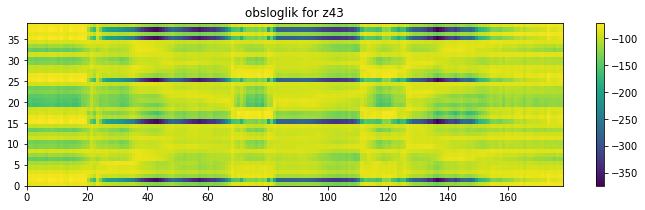

In [23]:
plt.figure(figsize=(12, 3))
plt.pcolormesh(np.array(obsloglik.T))
plt.colorbar()
plt.title('obsloglik for z43')  #'sil,ow,sil'
plt.show()

In [24]:
stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans
                  for stateid in range(nstates[phone])]

In [25]:
len(stateTrans)

39

In [26]:
lmfcc.shape

(178, 13)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


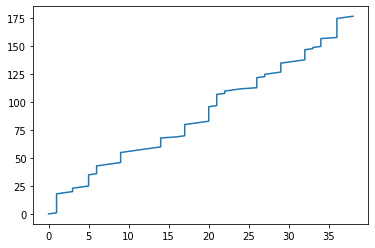

In [27]:
viterbi_loglik, viterbi_path = viterbi(obsloglik, np.log(utteranceHMM['startprob']), np.log(utteranceHMM['transmat']), True)
plt.plot(viterbi_path, np.arange(len(viterbi_path)))

In [28]:
viterbiStateTrans = forcedAlignment(lmfcc, phoneHMMs, phoneTrans)

/Users/flora/Desktop/KU/DT2119/lab3/dt2119_lab3_2019-04-25/lab3_proto.py:57: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['startprob']),
/Users/flora/Desktop/KU/DT2119/lab3/dt2119_lab3_2019-04-25/lab3_proto.py:58: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['transmat']),


In [29]:
viterbiStateTrans

['sil_0',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_2',
 'z_0',
 'z_0',
 'z_0',
 'z_0',
 'z_1',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_1',
 'iy_2',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_1',
 'r_2',
 'ow_0',
 'ow_1',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'f_0',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_2',
 'ao_0',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'r_0',
 'r_0',
 'r_0',
 'r_1',
 'r_2',
 'th_0',


In [30]:
len(viterbiStateTrans)

178

In [31]:
frames2trans(viterbiStateTrans, outfilename='z43a.lab')

'0 0.01 sil_0\n0.01 0.19000000000000003 sil_1\n0.19000000000000003 0.20000000000000004 sil_2\n0.20000000000000004 0.24000000000000007 z_0\n0.24000000000000007 0.25000000000000006 z_1\n0.25000000000000006 0.36000000000000015 z_2\n0.36000000000000015 0.4400000000000002 iy_0\n0.4400000000000002 0.45000000000000023 iy_1\n0.45000000000000023 0.46000000000000024 iy_2\n0.46000000000000024 0.5600000000000003 r_0\n0.5600000000000003 0.5700000000000003 r_1\n0.5700000000000003 0.5800000000000003 r_2\n0.5800000000000003 0.5900000000000003 ow_0\n0.5900000000000003 0.6000000000000003 ow_1\n0.6000000000000003 0.6900000000000004 ow_2\n0.6900000000000004 0.7000000000000004 f_0\n0.7000000000000004 0.8100000000000005 f_1\n0.8100000000000005 0.8200000000000005 f_2\n0.8200000000000005 0.8300000000000005 ao_0\n0.8300000000000005 0.9700000000000006 ao_1\n0.9700000000000006 1.0800000000000007 ao_2\n1.0800000000000007 1.1100000000000008 r_0\n1.1100000000000008 1.1200000000000008 r_1\n1.1200000000000008 1.13000

# feature extraction

In [54]:
def feature_extract(filedir):
    traindata = []
    count = 0
    for root, dirs, files in tqdm(os.walk(filedir)):
        for file in files:
            if file.endswith('.wav'):
                filename = os.path.join(root,file)
                samples, samplingrate = loadAudio(filename)
                lmfcc = mfcc(samples)
                spec = mspec(samples)
                wordTrans = list(path2info(filename)[2])
                phoneTrans = words2phones(wordTrans, prondict)
                targets = forcedAlignment(lmfcc, phoneHMMs, phoneTrans)
                targets = [stateList.index(t) for t in targets]
                
                traindata.append({'filename': filename, 'lmfcc': lmfcc,
                              'mspec': spec, 'targets': targets})
    
    return traindata

In [33]:
#train_data = feature_extract('tidigits/disc_4.1.1/tidigits/train')

In [ ]:
np.savez('train_data.npz', train_data=train_data)

In [55]:
test_data = feature_extract('tidigits/disc_4.2.1/tidigits/test')

/Users/flora/Desktop/KU/DT2119/lab3/dt2119_lab3_2019-04-25/lab3_proto.py:57: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['startprob']),
/Users/flora/Desktop/KU/DT2119/lab3/dt2119_lab3_2019-04-25/lab3_proto.py:58: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['transmat']),


In [57]:
np.savez('test_data.npz', test_data=test_data)

In [56]:
len(test_data)

8700

In [4]:
train_data = np.load('train_data.npz', allow_pickle=True)['traindata']
N = len(train_data)
n_val = round(N*0.1)
# # shuffle
indexes = np.random.permutation(N)
X = np.take(train_data,indexes)
X_val = X[:n_val]
X = X[n_val:]
np.savez('train.npz', X=X)
np.savez('val.npz', X_val=X_val)

In [5]:
len(train_data)

8623

In [6]:
X.shape

(7761,)

In [7]:
X[0]['lmfcc'].shape

(161, 13)

In [8]:
X[0]['mspec'].shape

(161, 40)

In [9]:
X_val.shape

(862,)

In [2]:
X = np.load('train.npz', allow_pickle=True)['X']
X_val = np.load('val.npz', allow_pickle=True)['X_val']
N = len(X) + len(X_val)
print(len(X)/N,len(X_val)/N)
# count men and women
## Trainingset
N_X_women = sum(1 for data in X if data['filename'].split("/")[-3] == 'woman')
N_X_man = len(X)-N_X_women
## Validationset
N_X_val_women = sum(1 for data in X_val if data['filename'].split("/")[-3] == 'woman')
N_X_val_man = len(X_val)-N_X_val_women


print("Trainign set: Women->",N_X_women,", Men->",N_X_man)
print("Validation set: Women->",N_X_val_women,", Men->",N_X_val_man)

0.9000347906760988 0.0999652093239012
Trainign set: Women-> 3922 , Men-> 3839
Validation set: Women-> 466 , Men-> 396


In [11]:
 N = sum([len(x['targets']) for x in X])

In [12]:
 N1 = sum([len(x['targets']) for x in X_val])

In [13]:
N1+N

1507057

# dynamic or nondynamic features

In [4]:
test_data = np.load('test_data.npz', allow_pickle=True)['test_data']
N = len(test_data)

In [15]:
d_lmfcc_train, d_mspec_train, train_y = get_features(X,dynamic=True)


In [16]:
d_lmfcc_train.shape

(1354605, 91)

In [19]:
len(train_y)

1354605

In [20]:
d_mspec_train.shape

(1354605, 280)

In [21]:
d_lmfcc_val, d_mspec_val, val_y = get_features(X_val,dynamic=True)

In [22]:
d_lmfcc_val.shape

(152452, 91)

In [23]:
len(val_y)

152452

In [24]:
d_lmfcc_test, d_mspec_test, test_y = get_features(test_data,dynamic=True)

In [26]:
d_lmfcc_test.shape

(1526682, 91)

In [27]:
len(test_y)

1526682

In [28]:
np.savez('d_lmfcc_train.npz', d_lmfcc_train=d_lmfcc_train)
np.savez('d_lmfcc_val.npz', d_lmfcc_val=d_lmfcc_val)
np.savez('d_lmfcc_test.npz', d_lmfcc_test=d_lmfcc_test)

np.savez('d_mspec_train.npz', d_mspec_train=d_mspec_train)
np.savez('d_mspec_val.npz', d_mspec_val=d_mspec_val)
np.savez('d_mspec_test.npz', d_mspec_test=d_mspec_test)

np.savez('train_y',train_y=train_y)
np.savez('val_y',val_y=val_y)
np.savez('test_y',test_y=test_y)

In [3]:
lmfcc_train_x, mspec_train_x, _ = get_features(X,dynamic=False)
lmfcc_val_x, mspec_val_x, _ = get_features(X_val,dynamic=False)


NameError: name 'test_data' is not defined

In [5]:
lmfcc_test_x, mspec_test_x, _ = get_features(test_data,dynamic=False)

In [6]:
lmfcc_train_x.shape

(1354605, 13)

In [7]:
mspec_train_x.shape

(1354605, 40)

In [8]:
lmfcc_test_x.shape

(1526682, 13)

In [50]:
len(X)

1359360

In [51]:
len(Y)

1356259

In [9]:
np.savez('lmfcc_train_x.npz', lmfcc_train_x=lmfcc_train_x)
np.savez('lmfcc_val_x.npz', lmfcc_val_x=lmfcc_val_x)
np.savez('lmfcc_test_x.npz', lmfcc_test_x=lmfcc_test_x)
np.savez('mspec_train_x.npz', mspec_train_x=mspec_train_x)
np.savez('mspec_val_x.npz', mspec_val_x=mspec_val_x)
np.savez('mspec_test_x.npz', mspec_test_x=mspec_test_x)

# Feature standardization

In [30]:
stateList = np.load('statelist.npz',allow_pickle=True)['arr_0']
output_dim = len(stateList)

train_y = np.load('train_y.npz',allow_pickle=True)['train_y']
val_y = np.load('val_y.npz',allow_pickle=True)['val_y']
test_y = np.load('test_y.npz',allow_pickle=True)['test_y']

In [32]:
len(train_y)

1354605

In [36]:
d_lmfcc_train = np.load('data/d_lmfcc_train.npz',allow_pickle=True)['d_lmfcc_train']

In [37]:
scaler = StandardScaler(copy=False)
scaler.fit_transform(d_lmfcc_train)

scaler.transform(d_lmfcc_val)
scaler.transform(d_lmfcc_test)

targets_train = np_utils.to_categorical(train_y, output_dim)
targets_val = np_utils.to_categorical(val_y, output_dim)
targets_test = np_utils.to_categorical(test_y, output_dim)

NameError: name 'd_lmfcc_val' is not defined

In [35]:
np.savez('lmfcc_train_s.npz', lmfcc_x=d_lmfcc_train, targets=targets_train)

In [36]:
np.savez('lmfcc_val_s.npz', lmfcc_x=d_lmfcc_val, targets=targets_val)

In [37]:
np.savez('lmfcc_test_s.npz', lmfcc_x=d_lmfcc_test, targets=targets_test)

In [11]:
d_mspec_train = np.load('data/d_mspec_train.npz',allow_pickle=True)['d_mspec_train']
d_mspec_val = np.load('data/d_mspec_val.npz',allow_pickle=True)['d_mspec_val']
d_mspec_test = np.load('data/d_mspec_test.npz',allow_pickle=True)['d_mspec_test']

In [13]:
scaler = StandardScaler(copy=False)
scaler.fit_transform(d_mspec_train)

scaler.transform(d_mspec_val)
scaler.transform(d_mspec_test)

targets_train = np_utils.to_categorical(train_y, output_dim)
targets_val = np_utils.to_categorical(val_y, output_dim)
targets_test = np_utils.to_categorical(test_y, output_dim)

In [14]:
d_mspec_train.shape

(1354605, 280)

In [15]:
len(targets_train)

1354605

In [16]:
np.savez('mspec_train_s.npz', mspec_x=d_mspec_train, targets=targets_train)
np.savez('mspec_val_s.npz', mspec_x=d_mspec_val, targets=targets_val)
np.savez('mspec_test_s.npz', mspec_x=d_mspec_test, targets=targets_test)

# non dynamic with standardization

In [17]:
nd_mspec_train = np.load('data/mspec_train_x.npz',allow_pickle=True)['mspec_train_x']
nd_mspec_val = np.load('data/mspec_val_x.npz',allow_pickle=True)['mspec_val_x']
nd_mspec_test = np.load('data/mspec_test_x.npz',allow_pickle=True)['mspec_test_x']

In [18]:
scaler = StandardScaler(copy=False)
scaler.fit_transform(nd_mspec_train)

scaler.transform(nd_mspec_val)
scaler.transform(nd_mspec_test)

array([[-1.57653019, -1.28155846, -1.27713497, ..., -1.05156597,
        -0.90554375, -1.0252739 ],
       [-1.5821835 , -1.34260223, -1.26027772, ..., -1.13299053,
        -1.17955396, -0.98614677],
       [-1.65155971, -1.29433833, -1.24469416, ..., -1.06115728,
        -1.11918212, -1.09141447],
       ...,
       [-1.55353135, -1.474273  , -1.33145622, ..., -1.22307411,
        -1.08899241, -1.1235334 ],
       [-1.63634312, -1.50301701, -1.51215407, ..., -0.96098165,
        -1.05290777, -1.05115951],
       [-1.42706706, -1.33062547, -1.34970021, ..., -1.18904179,
        -1.27074627, -0.9071792 ]])

In [19]:
np.savez('nd_mspec_train_s.npz', mspec_x=nd_mspec_train, targets=targets_train)
np.savez('nd_mspec_val_s.npz', mspec_x=nd_mspec_val, targets=targets_val)
np.savez('nd_mspec_test_s.npz', mspec_x=nd_mspec_test, targets=targets_test)

In [20]:
nd_lmfcc_train = np.load('data/lmfcc_train_x.npz',allow_pickle=True)['lmfcc_train_x']
nd_lmfcc_val = np.load('data/lmfcc_val_x.npz',allow_pickle=True)['lmfcc_val_x']
nd_lmfcc_test = np.load('data/lmfcc_test_x.npz',allow_pickle=True)['lmfcc_test_x']

In [21]:
scaler = StandardScaler(copy=False)
scaler.fit_transform(nd_lmfcc_train)

scaler.transform(nd_lmfcc_val)
scaler.transform(nd_lmfcc_test)

array([[-1.38543394, -0.68716551,  0.57433372, ..., -1.01308215,
         0.38238535,  1.14930945],
       [-1.39259565, -0.77512107,  0.4963348 , ..., -0.07928852,
         0.10483153, -0.6007093 ],
       [-1.38817847, -0.757598  ,  0.33928986, ...,  0.28866588,
         0.35665451,  0.2403985 ],
       ...,
       [-1.44163589, -0.76924561,  0.31654301, ..., -0.97911182,
        -0.37312281,  0.06725762],
       [-1.45822388, -0.76938505,  0.18697003, ...,  0.23978867,
        -0.2103942 , -0.25219686],
       [-1.49995334, -0.84360933,  0.68565916, ..., -1.14156832,
         0.09947619,  0.70661795]])

In [22]:
np.savez('nd_lmfcc_train_s.npz', lmfcc_x=nd_lmfcc_train, targets=targets_train)
np.savez('nd_lmfcc_val_s.npz', lmfcc_x=nd_lmfcc_val, targets=targets_val)
np.savez('nd_lmfcc_test_s.npz', lmfcc_x=nd_lmfcc_test, targets=targets_test)

# model building

In [38]:
X = None; Y = None; X_val = None; Y_val = None; X_test = None; Y_test = None

# Load data
with np.load('lmfcc_train_s.npz', allow_pickle=True) as data:
    X = data['lmfcc_x']
    Y = data['targets']
with np.load('lmfcc_val_s.npz', allow_pickle=True) as data:
    X_val = data['lmfcc_x']
    Y_val = data['targets']
with np.load('lmfcc_test_s.npz', allow_pickle=True) as data:
    X_test = data['lmfcc_x']
    Y_test = data['targets']

In [39]:
model = Sequential()
model.add(Dense(256, input_shape=(X.shape[1],), activation='relu') )
model.add(Dense(256, activation='relu'))
model.add(Dense(Y.shape[1], activation='sigmoid'))
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X, Y, epochs=5, batch_size=256, validation_data = (X_val, Y_val))







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1354605 samples, validate on 152452 samples
Epoch 1/5
1354605/1354605 [==============================] - 153s 113us/step - loss: 0.8268 - acc: 0.7317 - val_loss: 0.7150 - val_acc: 0.7640
Epoch 2/5
1354605/1354605 [==============================] - 88s 65us/step - loss: 0.6573 - acc: 0.7809 - val_loss: 0.6504 - val_acc: 0.7829
Epoch 3/5
1354605/1354605 [==============================] - 64s 47us/step - loss: 0.6111 - acc: 0.7942 - val_loss: 0.6236 - val_acc: 0.7905
Epoch 4/5
1354605/1354605 [==============================] - 63s 47us/step - loss: 0.5823 - acc: 0.8022 - val_loss: 0.6074 - val_acc: 0.7947
Epoch 5/5
1354605/1354605 [==============================] - 63s 46us/step - loss: nan - acc: 0.3843 - val_loss: nan - val_acc: 0.0133


In [8]:
len(test_example)

58880

In [3]:
filename = 'tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'
test_example, _= loadAudio(filename)
lmfcc = mfcc(test_example)
wordTrans = list(path2info(filename)[2])
phoneTrans = words2phones(wordTrans, prondict)
targets = forcedAlignment(lmfcc, phoneHMMs, phoneTrans)
targets = [stateList.index(t) for t in targets]

/Users/flora/Desktop/KU/DT2119/lab3/dt2119_lab3_2019-04-25/lab3_proto.py:58: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['startprob']),
/Users/flora/Desktop/KU/DT2119/lab3/dt2119_lab3_2019-04-25/lab3_proto.py:59: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['transmat']),


In [11]:
lmfcc[0]

array([ -22.91392389, -189.9582419 ,    7.40105799,  -95.76025599,
          4.7085325 ,  148.59745875,  118.13340686, -110.0042846 ,
        113.10298469,   53.95547105, -112.7883752 ,   41.12045179,
        -12.04285405])

In [10]:
len(targets)

TypeError: 'int' object is not subscriptable

In [49]:
wordTrans

['z', '4', '3']

In [13]:
lmfcc.shape

(178, 13)

In [7]:
def get_d_features(data):
    mfcc_features = np.zeros((178, 13*7))
    for j in range(178):
        for k in range(13):
            if k < 3 or k >= 10:
                mfcc_features[j,k*7:k*7+7] = np.pad(data[j,:],(3, 3),mode='reflect')[k:k+7]
            else:
                mfcc_features[j,k*7:k*7+7] = data[j, k-3:k+4]
    
    return mfcc_features

In [8]:
d_mfcc = get_d_features(lmfcc)

In [12]:
d_mfcc[0]

array([ -95.76025599,    7.40105799, -189.9582419 ,  -22.91392389,
       -189.9582419 ,    7.40105799,  -95.76025599,    7.40105799,
       -189.9582419 ,  -22.91392389, -189.9582419 ,    7.40105799,
        -95.76025599,    4.7085325 , -189.9582419 ,  -22.91392389,
       -189.9582419 ,    7.40105799,  -95.76025599,    4.7085325 ,
        148.59745875,  -22.91392389, -189.9582419 ,    7.40105799,
        -95.76025599,    4.7085325 ,  148.59745875,  118.13340686,
       -189.9582419 ,    7.40105799,  -95.76025599,    4.7085325 ,
        148.59745875,  118.13340686, -110.0042846 ,    7.40105799,
        -95.76025599,    4.7085325 ,  148.59745875,  118.13340686,
       -110.0042846 ,  113.10298469,  -95.76025599,    4.7085325 ,
        148.59745875,  118.13340686, -110.0042846 ,  113.10298469,
         53.95547105,    4.7085325 ,  148.59745875,  118.13340686,
       -110.0042846 ,  113.10298469,   53.95547105, -112.7883752 ,
        148.59745875,  118.13340686, -110.0042846 ,  113.10298

In [45]:
d_mfcc = scaler.transform(d_mfcc)

In [48]:
np.savez('test_z43a.npz',features=d_mfcc, targets=targets )

In [15]:
d_lmfcc_train = np.load('data/d_lmfcc_train.npz',allow_pickle=True)['d_lmfcc_train']

In [16]:
scaler = StandardScaler(copy=False)
scaler.fit(d_lmfcc_train)
scaler.transform(d_mfcc)

array([[-1.51275927, -0.15233423,  0.11455398, ..., -0.12505802,
         0.2289835 , -0.28767328],
       [-1.51168861, -0.15341222,  0.11462786, ..., -0.13669546,
         0.22973936, -0.2927499 ],
       [-1.51236982, -0.15440408,  0.11417378, ..., -0.1277345 ,
         0.22970169, -0.29330938],
       ...,
       [-1.51265691, -0.15295928,  0.12062995, ..., -0.13126052,
         0.22326076, -0.28560796],
       [-1.51079325, -0.15312734,  0.11995117, ..., -0.13086648,
         0.23206118, -0.28590031],
       [-1.51136868, -0.15388852,  0.11965901, ..., -0.12592719,
         0.2312587 , -0.28863562]])

In [ ]:
scaler = StandardScaler(copy=False)
scaler.fit_transform(d_mfcc)

In [17]:
np.savez('test_z43a1.npz',features=d_mfcc, targets=targets )